In [1]:
# required modules
import re
import requests
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings(action='ignore')

# use Stata in Python environment
import os
import sys
# sys.path.append('/Applications/Stata/utilities')
os.chdir('/Applications/Stata/utilities')
try:
    from pystata import config
except:
    !pip install pystata
    from pystata import config
config.init('se')


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user network, expiring 31 Jul 2023
Serial number: 401709315392
  Licensed to: Weiyue Li
               UCSD

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000; see help set_maxvar.


In [2]:
os.chdir('/Users/larry/Wage-Gap-Analysis')
data = pd.read_csv('cps_00001.csv.gz', compression='gzip', error_bad_lines=False)
print("Orginal Dataset Shape:", data.shape)
print("Official description for each column:")
for col in data: 
    print(f"https://cps.ipums.org/cps-action/variables/{col}")
data = data[['YEAR', 'SEX', 'REGION', 'WKSTAT', 'EDUC', 'OCC', 'INCWAGE']]
display(data.head())

Orginal Dataset Shape: (2977215, 25)
Official description for each column:
https://cps.ipums.org/cps-action/variables/YEAR
https://cps.ipums.org/cps-action/variables/SERIAL
https://cps.ipums.org/cps-action/variables/MONTH
https://cps.ipums.org/cps-action/variables/HWTFINL
https://cps.ipums.org/cps-action/variables/CPSID
https://cps.ipums.org/cps-action/variables/ASECFLAG
https://cps.ipums.org/cps-action/variables/ASECWTH
https://cps.ipums.org/cps-action/variables/REGION
https://cps.ipums.org/cps-action/variables/PERNUM
https://cps.ipums.org/cps-action/variables/WTFINL
https://cps.ipums.org/cps-action/variables/CPSIDP
https://cps.ipums.org/cps-action/variables/ASECWT
https://cps.ipums.org/cps-action/variables/AGE
https://cps.ipums.org/cps-action/variables/SEX
https://cps.ipums.org/cps-action/variables/RACE
https://cps.ipums.org/cps-action/variables/MARST
https://cps.ipums.org/cps-action/variables/EMPSTAT
https://cps.ipums.org/cps-action/variables/OCC
https://cps.ipums.org/cps-action/var

,YEAR,SEX,REGION,WKSTAT,EDUC,OCC,INCWAGE
0,2020,2,11,11,73,440,52500.0
1,2020,1,11,99,73,0,56000.0
2,2020,1,11,11,73,9121,34000.0
3,2020,2,11,99,50,0,0.0
4,2020,2,11,11,73,5500,40000.0


In [3]:
def clean(df):
    df = df.copy()
    df = df[df['YEAR']>=2020]
    df = df[df['SEX'] != 9]
    df = df[(df['INCWAGE']!=99999999) & (df['INCWAGE']!=0)].dropna(subset=['INCWAGE'])
    df['LN_INCWAGE'] = df['INCWAGE'].apply(np.log)
    
    # keep all full time workers
    df = df[df['WKSTAT'] <= 13]
    # clean region
    
    df = df[df['REGION'] != 97]
    regions = {11:'NORTHEAST', 12:'NORTHEAST', 21: 'MIDWEST', 22: 'MIDWEST', 31: 'SOUTH', 32: 'SOUTH', 33: 'SOUTH', 41: 'WEST', 42: 'WEST'}
    df['REGION'] = df['REGION'].replace(regions)
    
    # clean education
    df = df[df['EDUC'] >= 10]
    
    education = {j:'HS' if j <= 73 else 'COLLEGE' if j < 123 else 'GRAD' for j in range(126)}
    df['EDUC'] = df['EDUC'].replace(education)
    
    # clean occupations
    df['is_male'] = df['SEX'] == 1
    male, equal, female = classify_occ(df)
    male_dict, equal_dict, female_dict = {i[0]:'MALE_DOMINANT' for i in male}, \
                                        {i[0]:'EQUAL_DOMINANT' for i in equal}, \
                                        {i[0]:'FEMALE_DOMINANT' for i in female}
    occupation = {}
    occupation.update(male_dict)
    occupation.update(female_dict)
    occupation.update(equal_dict)
    df['OCCU'] = df['OCC'].copy()
    df['OCCU'] = df['OCCU'].replace(occupation)
            
    
    return df

def classify_occ(df):
    df = df.copy()
    occs = list(df['OCC'].unique())
    if 'is_male' in df.columns:
        pass
    else:
        df['is_male'] = df['SEX'] == 1
    male_dominant = []
    equal_dominant = []
    female_dominant = []
    for occ in occs:
        gender_dict = df[df['OCC'] == occ]['is_male'].value_counts(normalize=True).to_dict()
        prop = gender_dict.get(True)
        if isinstance(prop, float) and (prop >= 0.7):
            male_dominant.append([occ, prop])
        elif isinstance(prop, float) and (prop >= 0.3):
            equal_dominant.append([occ, prop])
        elif isinstance(prop, float):
            female_dominant.append([occ, prop])
        else:
            female_dominant.append([occ, 0])
    male_dominant = sorted(male_dominant, key=lambda x: x[-1], reverse=True)
    equal_dominant = sorted(equal_dominant, key=lambda x: x[-1], reverse=True)
    female_dominant = sorted(female_dominant, key=lambda x: x[-1], reverse=True)
    return male_dominant, equal_dominant, female_dominant

df = clean(data)
df.head()

,YEAR,SEX,REGION,WKSTAT,EDUC,OCC,INCWAGE,LN_INCWAGE,is_male,OCCU
0,2020,2,NORTHEAST,11,HS,440,52500.0,10.868568,False,EQUAL_DOMINANT
2,2020,1,NORTHEAST,11,HS,9121,34000.0,10.434116,True,EQUAL_DOMINANT
4,2020,2,NORTHEAST,11,HS,5500,40000.0,10.596635,False,EQUAL_DOMINANT
8,2020,1,NORTHEAST,11,COLLEGE,3870,58000.0,10.968198,True,MALE_DOMINANT
14,2020,2,NORTHEAST,11,COLLEGE,3150,42000.0,10.645425,False,FEMALE_DOMINANT


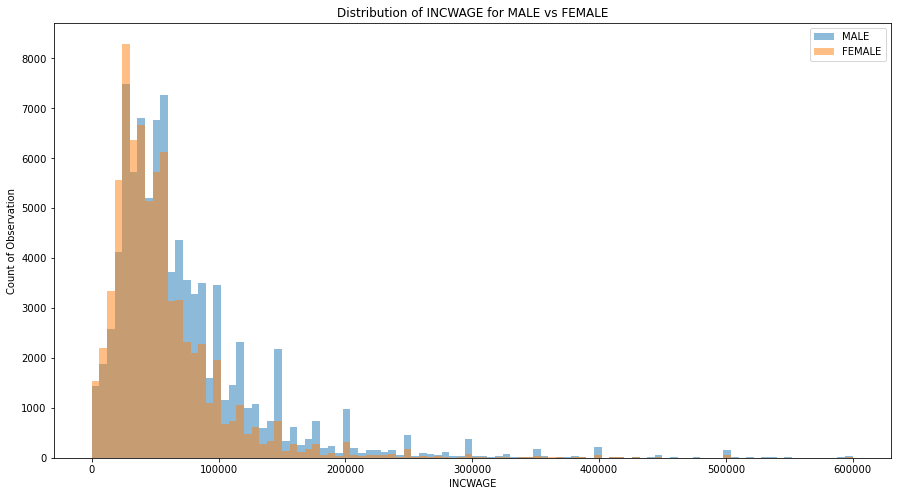

In [4]:
dur_1 = np.array(df[(df['is_male']) & (df['INCWAGE'] <= 6e5)]['INCWAGE'])
dur_2 = np.array(df[(df['is_male']==False) & (df['INCWAGE'] <= 6e5)]['INCWAGE'])
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
y_1, binEdges_1 = np.histogram(dur_1, bins=100)
y_2, binEdges_2 = np.histogram(dur_2, bins=100)
bincenters_1 = 0.5 * (binEdges_1[1:] + binEdges_1[:-1])
bincenters_2 = 0.5 * (binEdges_2[1:] + binEdges_2[:-1])
plt.hist(dur_1, bins=100, alpha=0.5, label='MALE')
plt.hist(dur_2, bins=100, alpha=0.5, label='FEMALE')
plt.xlabel("INCWAGE")
plt.ylabel("Count of Observation")
plt.title(f"Distribution of INCWAGE for {'MALE'} vs {'FEMALE'}")
plt.legend(loc='upper right')
plt.savefig('male-v-female.png')
plt.show()

In [5]:
# scrape the occupation description from the web
r = requests.get("https://cps.ipums.org/cps/codes/occ_2020_codes.shtml")
soup = BeautifulSoup(r.text)
occ_code = [i.text for i in soup.find_all("dt")]
occ_des = [i.text for i in soup.find_all("dd")]
occ_dict = dict(zip(occ_code, occ_des))
def find_occ(occ):
    occ = str(occ)
    occ = occ[occ.find("_")+1:]
    while len(occ) < 4:
        occ = "0" + occ
    return occ_dict[occ]

male_dominant, equal_dominant, female_dominant = classify_occ(df)

male_dominant_name = [find_occ(occ[0]) + f": {occ[1]*100}% male" for occ in male_dominant]
equal_dominant_name = [find_occ(occ[0]) + f": {occ[1]*100}% male" for occ in equal_dominant]
female_dominant_name = [find_occ(occ[0]) + f": {occ[1]*100}% male" for occ in female_dominant]

In [6]:
# # uncomment to see the male-dominated occupations' names
# male_dominant_name

In [7]:
# # uncomment to see the equal-dominated occupations' names
# equal_dominant_name

In [8]:
# # uncomment to see the female-dominated occupations' names
# female_dominant_name

In [9]:
encoded = pd.get_dummies(df, columns=['REGION', 'SEX','EDUC', 'OCCU'], drop_first=True)
encoded['MALE'] = 1 - encoded['SEX_2']

In [10]:
# interaction terms
encoded['MALE_IN_OCC_MALE'] = encoded['OCCU_MALE_DOMINANT'] * encoded['is_male']
encoded['MALE_IN_OCC_FEMALE'] = encoded['OCCU_FEMALE_DOMINANT'] * encoded['is_male']

In [11]:
# difference of mean wage between sex in female-dominated occupation
df[df['OCCU'] == 'FEMALE_DOMINANT'].groupby('SEX').mean()[['INCWAGE']].diff().iloc[-1,0]

-14241.636915508869

In [12]:
# difference of mean wage between sex in male-dominated occupation
df[df['OCCU'] == 'MALE_DOMINANT'].groupby('SEX').mean()[['INCWAGE']].diff().iloc[-1,0]

-1158.1255148140044

In [13]:
# difference of mean wage between sex in equal-dominated occupation
df[df['OCCU'] == 'EQUAL_DOMINANT'].groupby('SEX').mean()[['INCWAGE']].diff().iloc[-1,0]

-23311.76270912263

In [14]:
encoded = encoded[['LN_INCWAGE',
       'REGION_NORTHEAST', 'REGION_SOUTH', 'REGION_WEST', 'EDUC_GRAD',
       'EDUC_HS', 'OCCU_FEMALE_DOMINANT', 'OCCU_MALE_DOMINANT', 'MALE',
       'MALE_IN_OCC_MALE', 'MALE_IN_OCC_FEMALE']].rename(columns={'OCCU_FEMALE_DOMINANT': 'OCC_FEMALE', 'OCCU_MALE_DOMINANT': 'OCC_MALE'})
display(encoded.head())
encoded.to_csv('data.csv', index=False)

,LN_INCWAGE,REGION_NORTHEAST,REGION_SOUTH,REGION_WEST,EDUC_GRAD,EDUC_HS,OCC_FEMALE,OCC_MALE,MALE,MALE_IN_OCC_MALE,MALE_IN_OCC_FEMALE
0,10.868568,1,0,0,0,1,0,0,0,0,0
2,10.434116,1,0,0,0,1,0,0,1,0,0
4,10.596635,1,0,0,0,1,0,0,0,0,0
8,10.968198,1,0,0,0,0,0,1,1,1,0
14,10.645425,1,0,0,0,0,1,0,0,0,0


## Regression Model

In [15]:
%%stata
clear all
set more off
capture cd "/Users/larry/Wag-Gap-Analysis"
import delimited "data.csv"
sum


. clear all

. set more off

. capture cd "/Users/larry/Wag-Gap-Analysis"

. import delimited "data.csv"
(encoding automatically selected: ISO-8859-1)
(11 vars, 165,721 obs)

. sum

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
  ln_incwage |    165,721    10.82999    .8461554   .6931472   14.55745
region_nor~t |    165,721    .1530524    .3600391          0          1
region_south |    165,721    .3697842    .4827476          0          1
 region_west |    165,721    .2819437    .4499474          0          1
   educ_grad |    165,721    .1686751    .3744658          0          1
-------------+---------------------------------------------------------
     educ_hs |    165,721    .3088866    .4620357          0          1
  occ_female |    165,721     .240923     .427645          0          1
    occ_male |    165,721      .34403    .4750523          0          1
        male |    165,721

In [16]:
%%stata
eststo: regress ln_incwage region_northeast region_south region_west male occ_female occ_male educ_grad educ_hs

eststo: regress ln_incwage region_northeast region_south region_west male occ_female occ_male educ_grad educ_hs male_in_occ_male male_in_occ_female

esttab using regression.tex, replace label nostar ///
title(Regression table\label{tab1})


. eststo: regress ln_incwage region_northeast region_south region_west male occ
> _female occ_male educ_grad educ_hs

      Source |       SS           df       MS      Number of obs   =   165,721
-------------+----------------------------------   F(8, 165712)    =   4483.27
       Model |  21111.3663         8  2638.92079   Prob > F        =    0.0000
    Residual |  97540.6624   165,712  .588615564   R-squared       =    0.1779
-------------+----------------------------------   Adj R-squared   =    0.1779
       Total |  118652.029   165,720  .715978933   Root MSE        =    .76721

------------------------------------------------------------------------------
  ln_incwage | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
region_nor~t |    .091284   .0064443    14.17   0.000     .0786534    .1039146
region_south |  -.0368776   .0052759    -6.99   0.000    -.0472182    -.026537
 region_wes

In [17]:
# # b4+b10
# .2554662 -.1228433

In [18]:
# # b4+b9
# .2554662 -.0723224

In [19]:
# # b4
# .2554662

In [20]:
%%stata
test male + occ_female + male_in_occ_female = occ_female


 ( 1)  male + male_in_occ_female = 0

       F(  1,165710) =  163.55
            Prob > F =    0.0000


In [21]:
%%stata
test male + occ_male +  male_in_occ_male = occ_male


 ( 1)  male + male_in_occ_male = 0

       F(  1,165710) =  393.38
            Prob > F =    0.0000


In [22]:
%%stata
test male = 0


 ( 1)  male = 0

       F(  1,165710) = 1905.38
            Prob > F =    0.0000
